In [1]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
d = h5py.File('./data/electrons-10GeV-incidence-perp.hdf5', 'r')

In [3]:
first = d['layer_0'][:]
second = d['layer_1'][:]
third = d['layer_2'][:]

In [4]:
sizes = [first.shape[1], first.shape[2], second.shape[1], second.shape[2], third.shape[1], third.shape[2]]

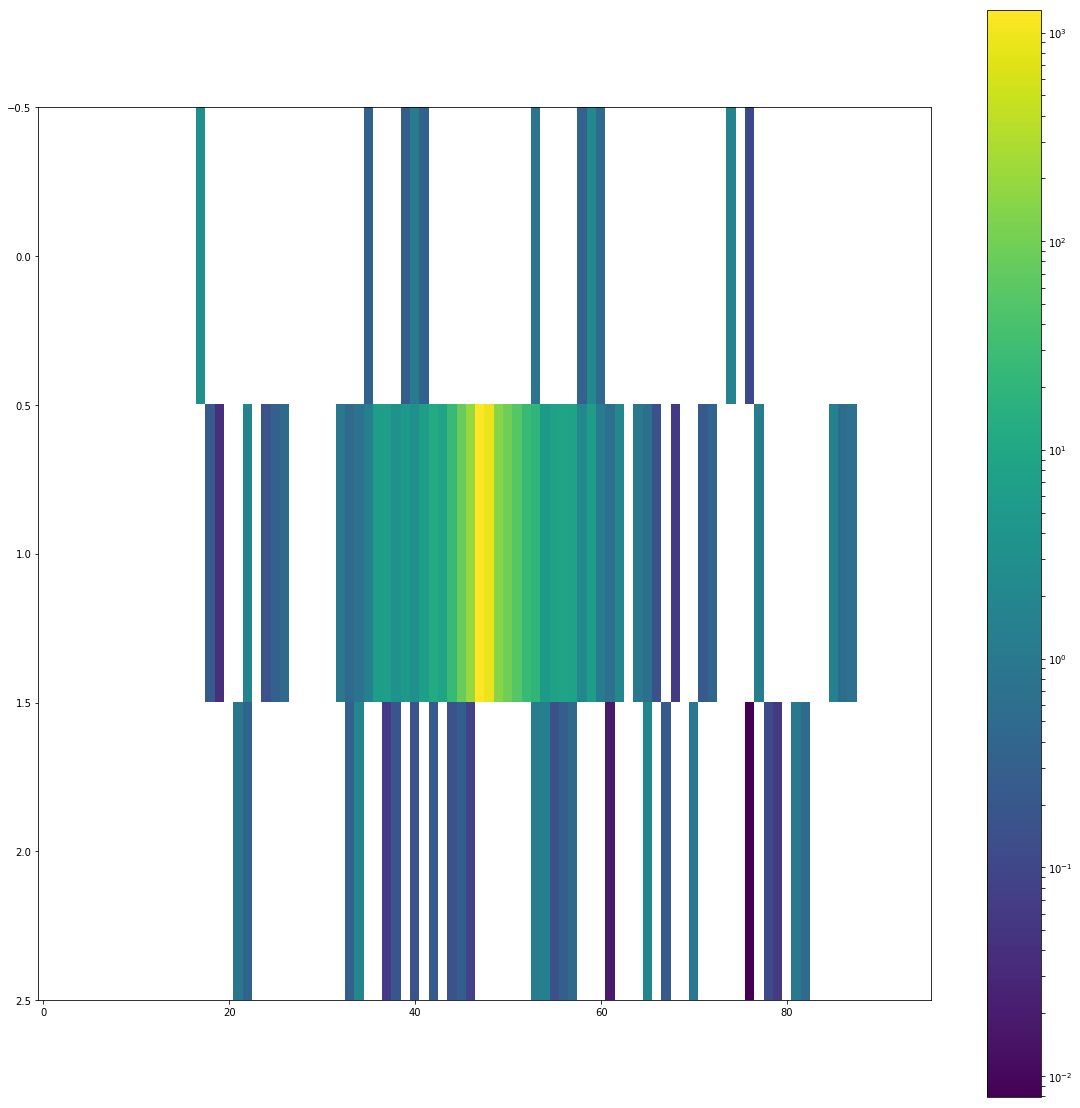

In [4]:
imageix = 0
plt.figure(figsize=(20,20))
plt.imshow(first[imageix], aspect=float(first.shape[2])/first.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()
# aspect is needed to make this 3*96 image come out nice

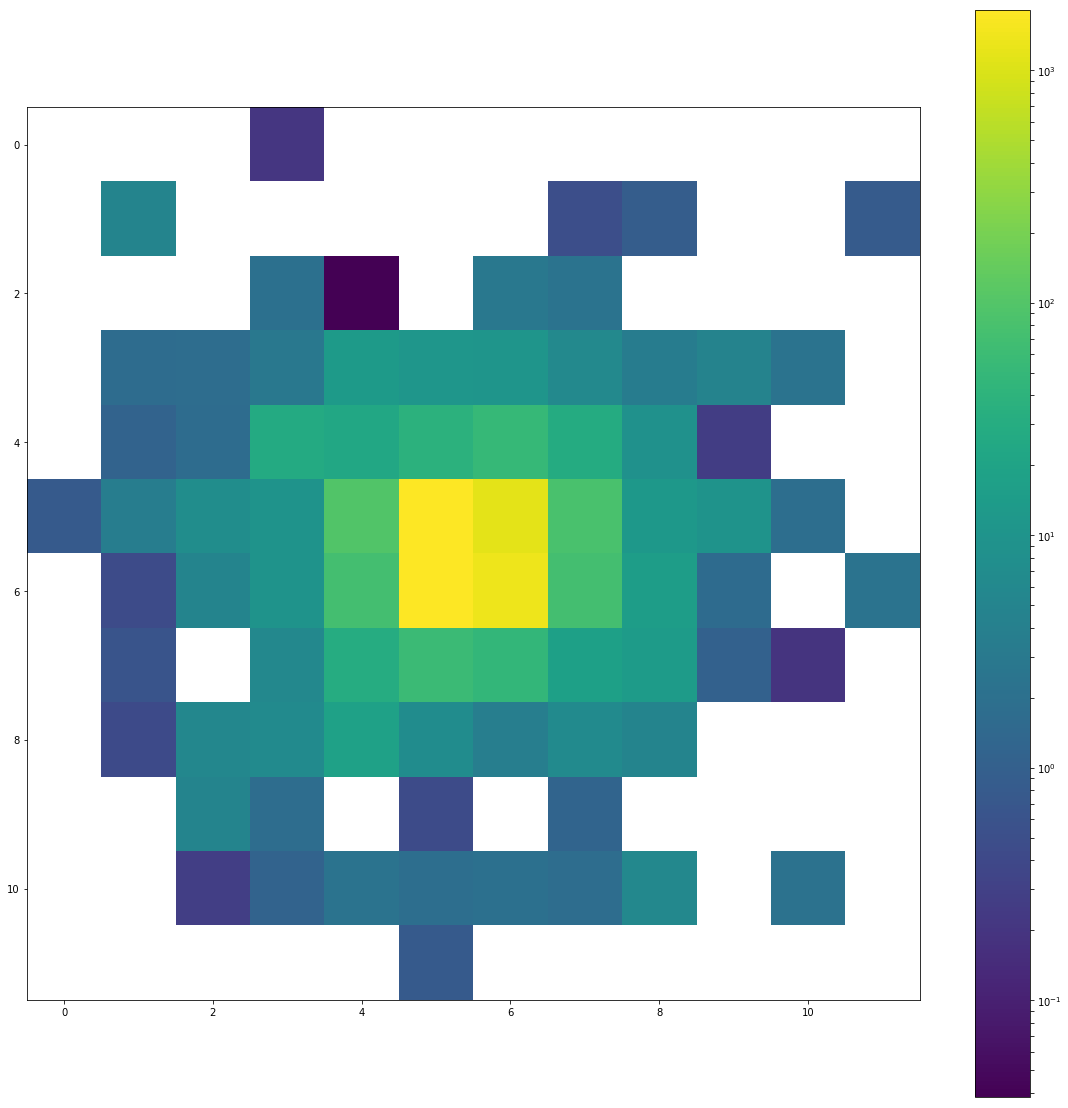

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(second[imageix], aspect=float(second.shape[2])/second.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()

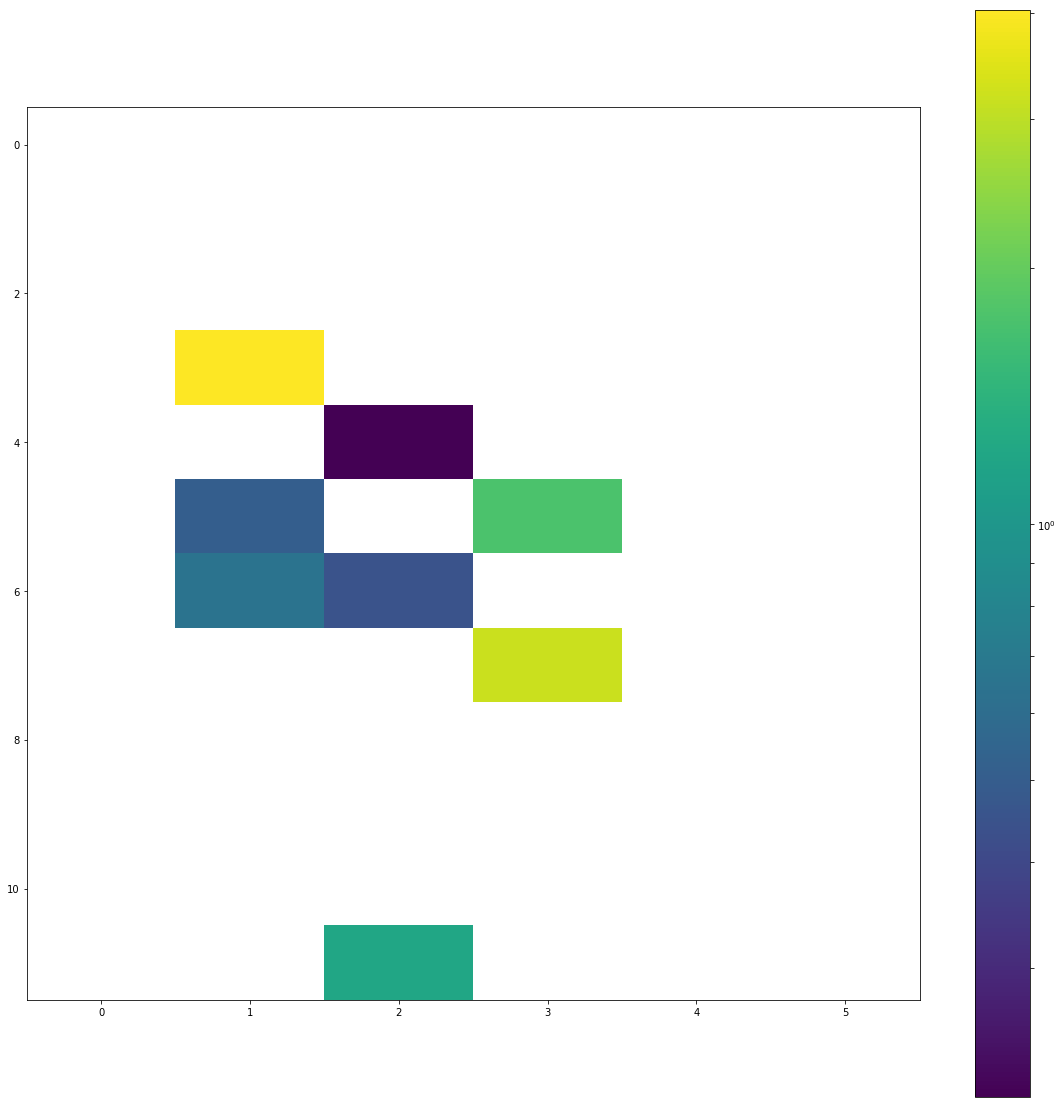

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(third[imageix], aspect=float(third.shape[2])/third.shape[1], interpolation='nearest', norm=LogNorm())
plt.colorbar()

In [1]:
import keras.backend as K
from keras.layers import (Input, Dense, Reshape, Flatten, Embedding, merge,
                          Dropout, BatchNormalization, Activation)

from keras.layers.advanced_activations import LeakyReLU

from keras.layers.local import LocallyConnected2D
from keras.layers.convolutional import UpSampling2D, Conv2D, ZeroPadding2D

from keras.models import Model, Sequential

K.set_image_dim_ordering('tf')


#def generator(latent_size, return_intermediate=False):
def generator(latent_size, img_shape, return_intermediate=False):
    '''
    img_shape = tuple of image eta-phi dimensions (e.g. (3, 96))
    '''

    z = Input(shape=(latent_size, ))

    # DCGAN-style project & reshape,
    #x = Dense(5 * 98 * 12, input_dim=latent_size)(z)
    #x = Reshape((5, 98, 12))(x)
    x = Dense((img_shape[0] + 2) * (img_shape[1] + 2) * 12, input_dim=latent_size)(z)
    x = Reshape((img_shape[0] + 2, img_shape[1] + 2, 12))(x)

    # block 1: (None, 5, 98, 12) => (None, 5, 98, 8),
    x = Conv2D(8, (2, 2), padding='same', kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    # block 2: (None, 5, 98, 32) => (None, 4, 97, 6),
    #ZeroPadding2D((2, 2)),
    x = LocallyConnected2D(6, (2, 2), kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
            
    # block 3: (None, 4, 97, 6) => (None, 3, 96, 1),
    x = LocallyConnected2D(1, (2, 2), use_bias=False, kernel_initializer='glorot_normal')(x)
    y = Activation('relu')(x)
    
    return Model(z, y)

Using TensorFlow backend.


In [27]:
noise = np.random.normal(0, 1, (50000, 500))

In [5]:
G = generator(500, (12, 12))

In [6]:
G.load_weights('./weights/4-2-17/params_generator_epoch_012.hdf5')

In [28]:
images = G.predict(noise, verbose=True)

49952/50000 [============================>.] - ETA: 0s 

In [29]:
images *= 500

In [30]:
images = np.squeeze(images)

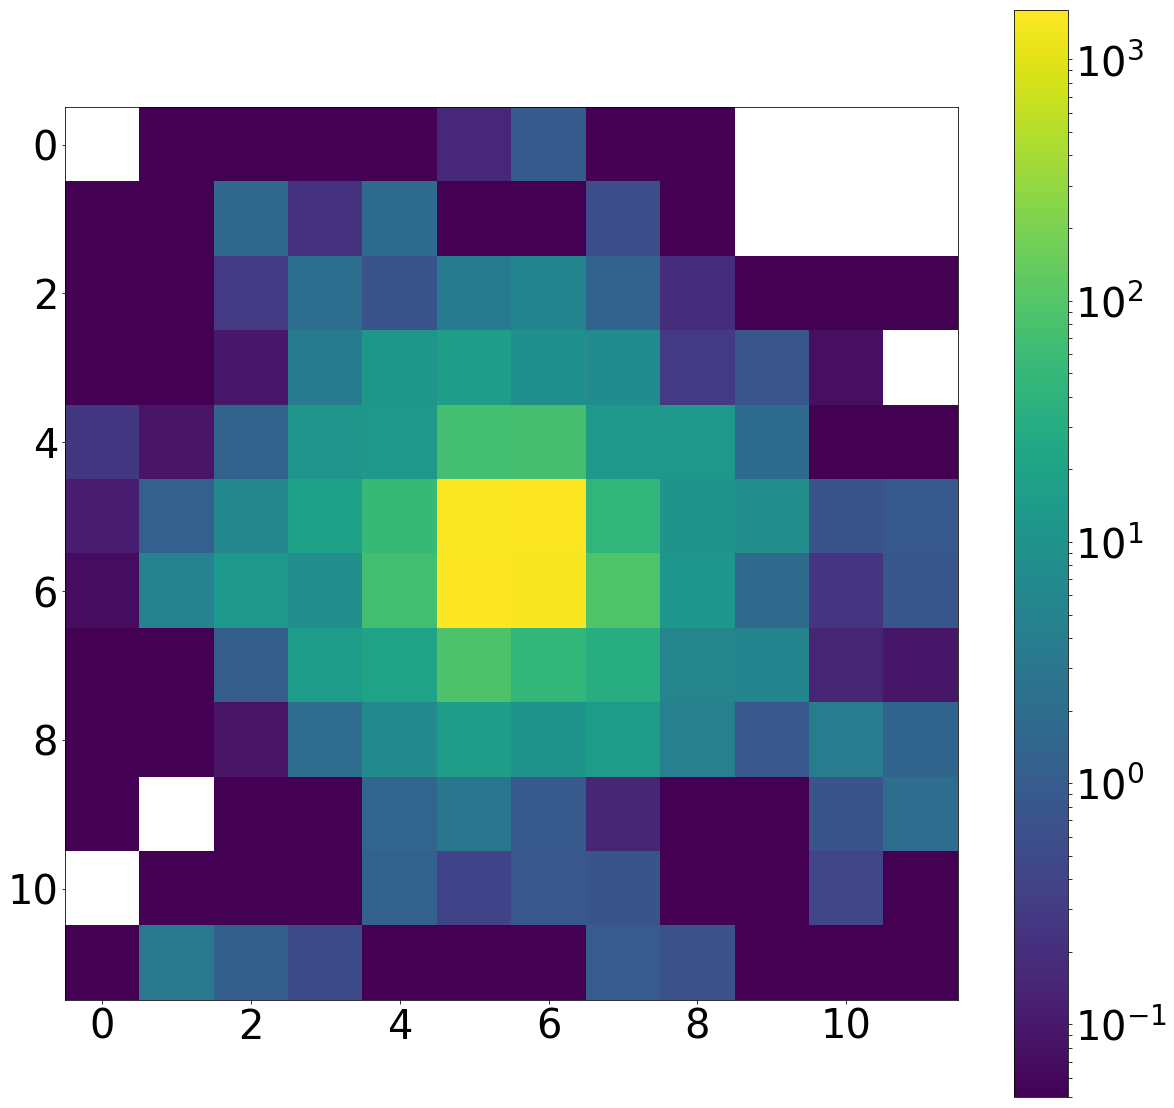

In [31]:
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(images.mean(axis=0), interpolation='nearest', norm=LogNorm(vmin=second.mean(axis=0).min()))
plt.colorbar()

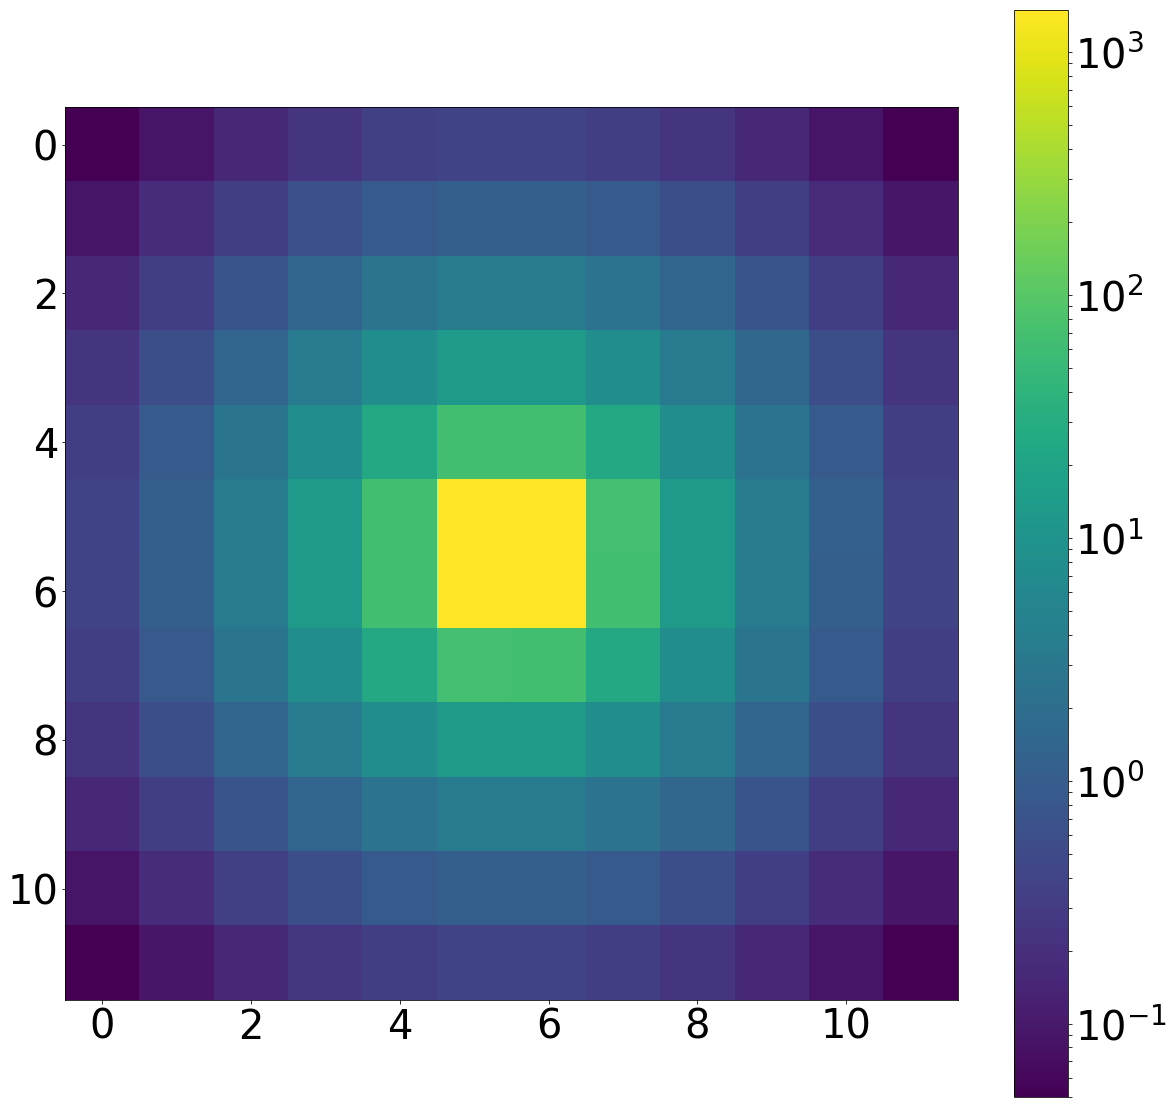

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(second.mean(axis=0), interpolation='nearest', norm=LogNorm())
plt.colorbar()

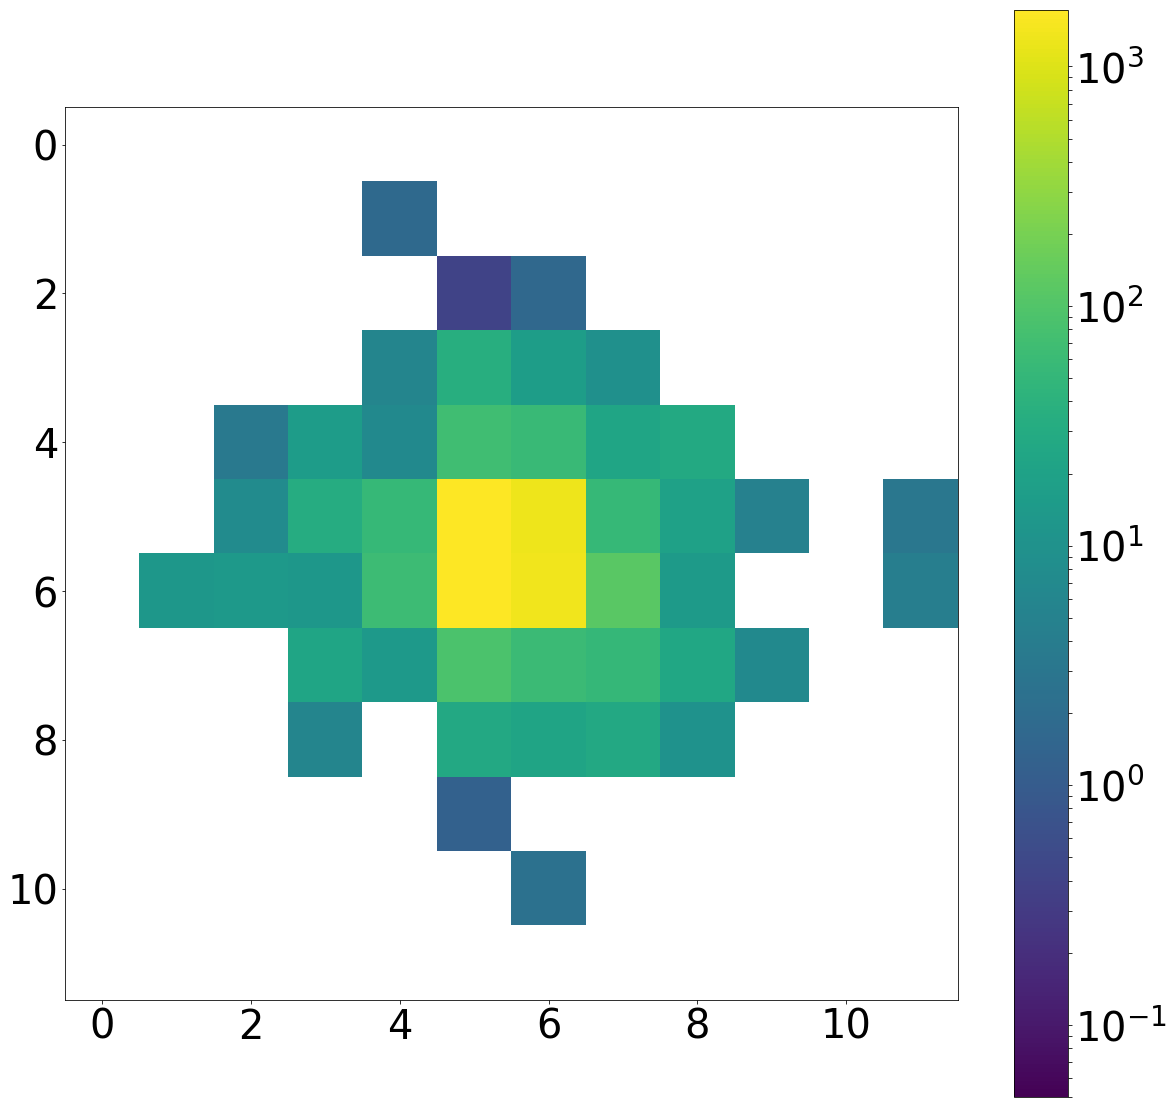

In [34]:
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(images[110], interpolation='nearest', norm=LogNorm(vmin=second.mean(axis=0).min()))
plt.colorbar()

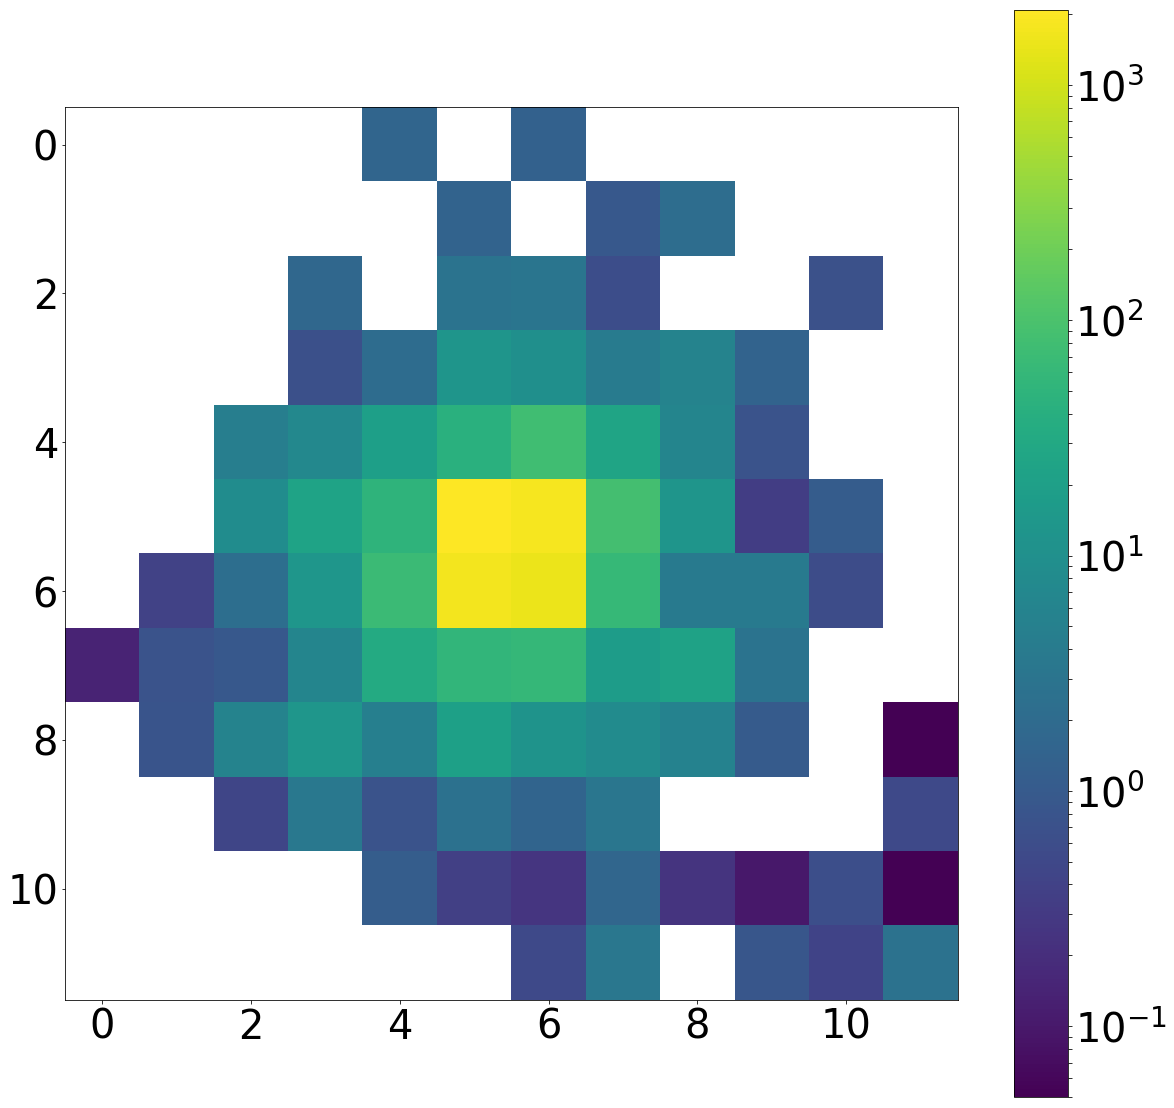

In [35]:
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(second[110], interpolation='nearest', norm=LogNorm(vmin=second.mean(axis=0).min()))
plt.colorbar()

In [5]:
import keras.backend as K
from keras.layers import (Input, Dense, Reshape, Flatten, Lambda, merge,
                          Dropout, BatchNormalization, Embedding, Activation)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import (UpSampling2D, Conv2D, ZeroPadding2D,
                                        AveragePooling2D)
from keras.layers.local import LocallyConnected2D
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from keras.optimizers import Adam

K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [6]:
import keras.backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints, activations

def minibatch_discriminator(x):
    """ Computes minibatch discrimination features from input tensor x"""
    diffs = K.expand_dims(x, 3) - \
        K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    l1_norm = K.sum(K.abs(diffs), axis=2)
    return K.sum(K.exp(-l1_norm), axis=2)


def minibatch_output_shape(input_shape):
    """ Computes output shape for a minibatch discrimination layer"""
    shape = list(input_shape)
    assert len(shape) == 3  # only valid for 3D tensors
    return tuple(shape[:2])


class Dense3D(Layer):

    """
    A 3D, trainable, dense tensor product layer
    """

    def __init__(self, first_dim, last_dim, init='glorot_uniform',
                 activation=None, weights=None,
                 W_regularizer=None, b_regularizer=None, activity_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, input_dim=None, **kwargs):

        self.init = initializers.get(init)
        self.activation = activations.get(activation)

        self.input_dim = input_dim
        self.first_dim = first_dim
        self.last_dim = last_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(Dense3D, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = self.add_weight(
            (self.first_dim, input_dim, self.last_dim),
            initializer=self.init,
            name='{}_W'.format(self.name),
            regularizer=self.W_regularizer,
            constraint=self.W_constraint
        )
        if self.bias:
            self.b = self.add_weight(
                (self.first_dim, self.last_dim),
                initializer='zero',
                name='{}_b'.format(self.name),
                regularizer=self.b_regularizer,
                constraint=self.b_constraint
            )
        else:
            self.b = None

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, x, mask=None):
        out = K.reshape(K.dot(x, self.W), (-1, self.first_dim, self.last_dim))
        if self.bias:
            out += self.b
        return self.activation(out)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.first_dim, self.last_dim)

    def get_config(self):
        config = {
            'first_dim': self.first_dim,
            'last_dim': self.last_dim,
            'init': self.init.__name__,
            'activation': self.activation.__name__,
            'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
            'b_regularizer': self.b_regularizer.get_config() if self.b_regularizer else None,
            'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
            'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
            'b_constraint': self.b_constraint.get_config() if self.b_constraint else None,
            'bias': self.bias,
            'input_dim': self.input_dim
        }
        base_config = super(Dense3D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [7]:
discr_inputs = [Input(shape=sizes[:2] + [1]), Input(shape=sizes[2:4] + [1]), Input(shape=sizes[4:] + [1])]
discr_inputs_middle = [Input(shape=sizes[:2] + [1]), Input(shape=sizes[2:4] + [1]), Input(shape=sizes[4:] + [1])]
features = []
#for image, image_middle in zip(discr_inputs, discr_inputs_middle):
# for image in discr_inputs:
for i in xrange(len(discr_inputs)):
    x = Conv2D(32, (2, 2), padding='same')(discr_inputs[i])
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    # block 2: 'same' bordered 3x3 locally connected block with batchnorm and
    # 2x2 subsampling
    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (3, 3), padding='valid', strides=(1, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # block 2: 'same' bordered 5x5 locally connected block with batchnorm
    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # block 3: 2x2 locally connected block with batchnorm and
    # 1x2 subsampling
    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(1, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    h = Flatten()(x)

    dnn = Model(inputs=discr_inputs[i], outputs=h)
    #evt_image = Input(shape=[int(a) for a in image.shape[1:]])#(img_shape[0], img_shape[1], 1))
    out = dnn(discr_inputs_middle[i])
    # out = dnn.outputs[0]
    #out = h 

    # nb of features to obtain
    nb_features = 20
    # dim of kernel space
    vspace_dim = 10

    # creates the kernel space for the minibatch discrimination
    K_x = Dense3D(nb_features, vspace_dim)(out)#(h)#(out)

    minibatch_featurizer = Lambda(minibatch_discriminator,
                              output_shape=minibatch_output_shape)

    # concat the minibatch features with the normal ones
    features.append(out)
#     features.append( 
#         merge(
#             [
#                 minibatch_featurizer(K_x),
#                 out #h
#             ],
#             mode='concat'
#         )
#     )

combined_output = Dense(1, activation='linear', name='discr_output')(
    Dense(64, activation='relu')(
        Dense(128, activation='relu')(
            merge(features, mode='concat'))))

discriminator = Model(
    inputs=discr_inputs_middle,
    outputs=combined_output)

discriminator.compile(
    optimizer=Adam(lr=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

/Users/mp744/Documents/CERN/external_dl_work/caloGAN/gan/lib/python2.7/site-packages/ipykernel/__main__.py:64: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/mp744/Documents/CERN/external_dl_work/caloGAN/gan/lib/python2.7/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [8]:
first /=(500)
second /=(500)
third/=(500)

In [24]:
plot_model(discriminator,
           to_file='discriminator.png',
           show_shapes=True,
           show_layer_names=True)

In [26]:
!open discriminator.png

In [10]:
discriminator.load_weights('./weights/test_params_discriminator_epoch_049.hdf5')

In [87]:
yhat = discriminator.predict([
    np.expand_dims(first[:1000], -1),
    np.expand_dims(second[:1000], -1),
    np.expand_dims(third[:1000], -1)],
      verbose=True,
      batch_size=200)

1000/1000 [==============================] - 35s      


In [88]:
yhat

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
      

In [11]:
latent_size = 500
latent = Input(shape=(latent_size, ), name='z')
from itertools import izip

def _pairwise(iterable):
    '''s -> (s0, s1), (s2, s3), (s4, s5), ...'''
    a = iter(iterable)
    return izip(a, a)

outputs = []
for img_shape in _pairwise(sizes):
    x = Dense((img_shape[0] + 2) * (img_shape[1] + 2) * 12)(latent)
    x = Reshape((img_shape[0] + 2, img_shape[1] + 2, 12))(x)
    # block 1: (None, 5, 98, 12) => (None, 5, 98, 8),
    x = Conv2D(8, (2, 2), padding='same', kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    # block 2: (None, 5, 98, 32) => (None, 4, 97, 6),
    #ZeroPadding2D((2, 2)),
    x = LocallyConnected2D(6, (2, 2), kernel_initializer='he_uniform')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    # block 3: (None, 4, 97, 6) => (None, 3, 96, 1),
    x = LocallyConnected2D(1, (2, 2), use_bias=False, kernel_initializer='glorot_normal')(x)
    y = Activation('relu')(x)
    outputs.append(y)

generator = Model(inputs=latent, outputs=outputs)
generator.compile(
    optimizer=Adam(lr=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)
# plot_model(generator,
#            to_file='generator.png',
#            show_shapes=True,
#            show_layer_names=True)

In [12]:
noise = np.random.normal(0, 1, (10000, latent_size))

In [13]:
generator.load_weights('./weights/test_params_generator_epoch_049.hdf5')

In [14]:
gen_images = generator.predict(noise, verbose=False)

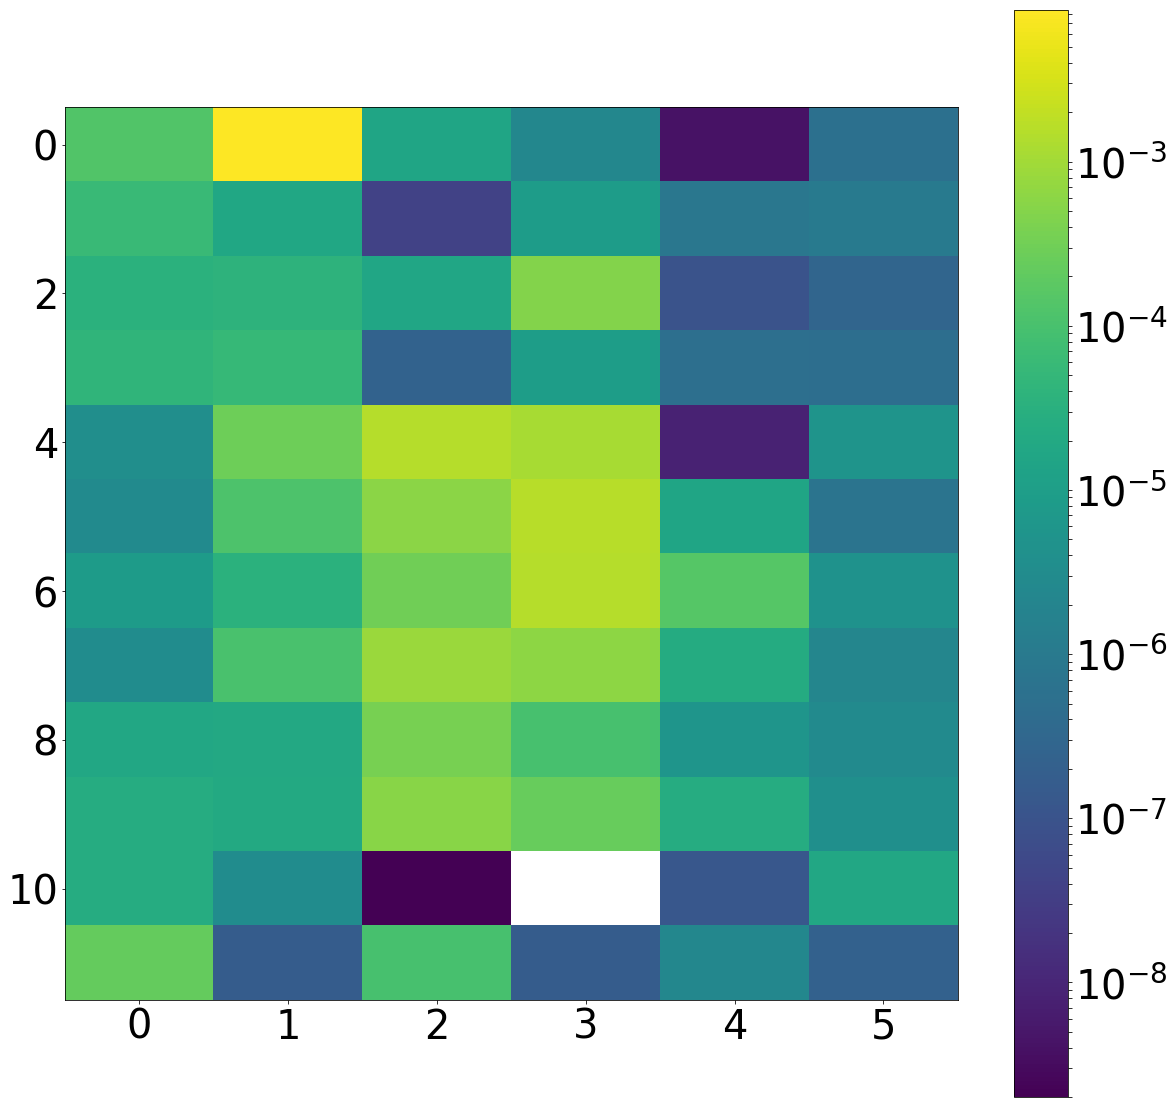

In [15]:
i = 2
plt.figure(figsize=(20,20))
matplotlib.rcParams.update({'font.size': 40})
plt.imshow(np.squeeze(gen_images[i]).mean(axis=0), interpolation='nearest',
           aspect=sizes[1+(i*2)] / float(sizes[(0)+(i*2)]),
           norm=LogNorm())
plt.colorbar()

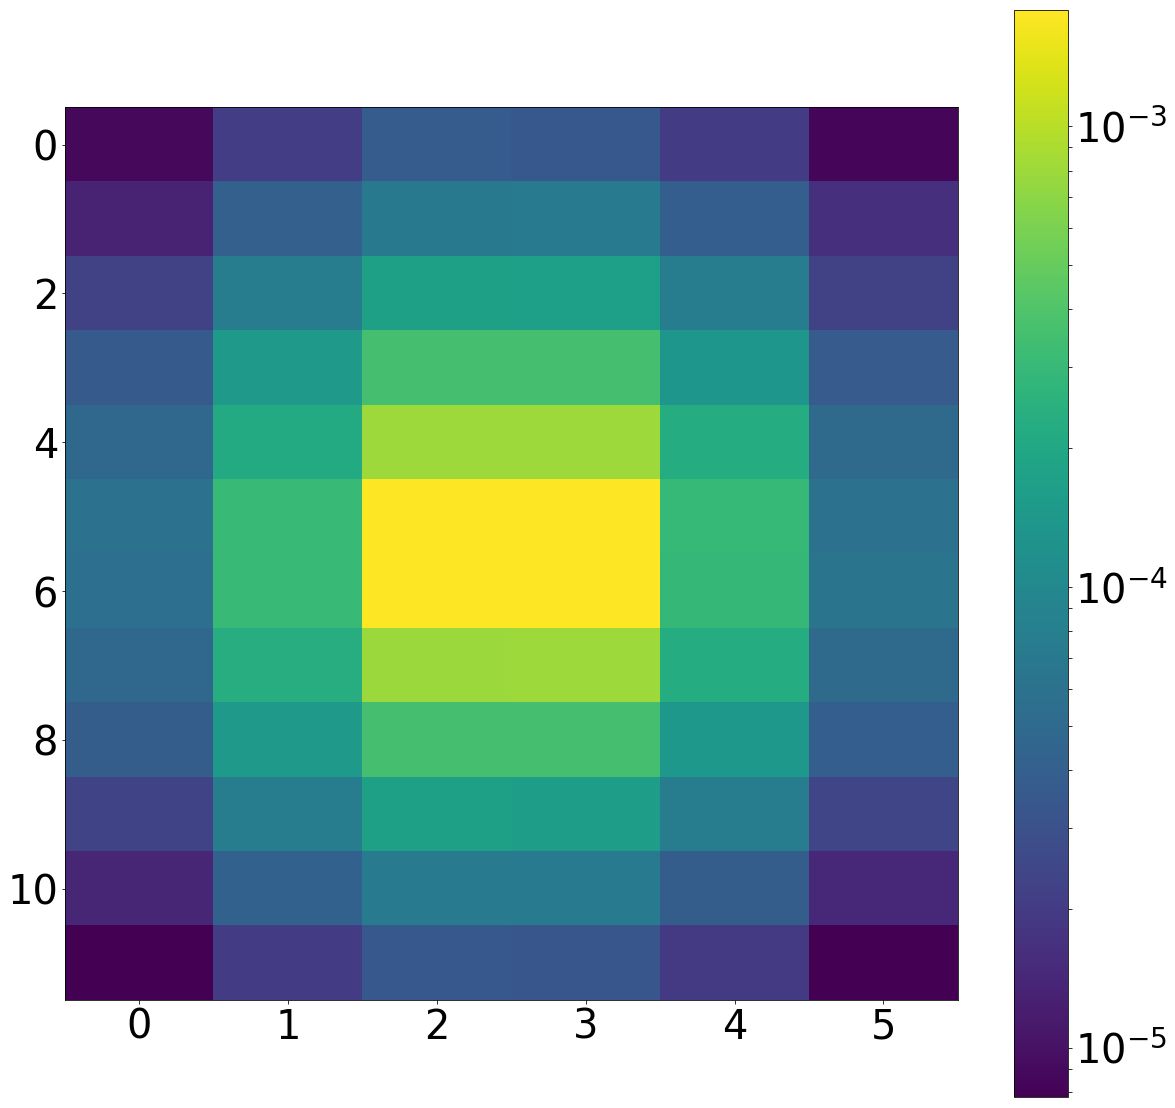

In [55]:
plt.figure(figsize=(20,20))
plt.imshow(third.mean(axis=0), interpolation='nearest',
           aspect=sizes[1+(i*2)] / float(sizes[(0)+(i*2)]),
           norm=LogNorm())
plt.colorbar()

In [69]:
yhat_fake = discriminator.predict(
      gen_images,
      verbose=True,
      batch_size=200)

1000/1000 [==============================] - 73s     


In [70]:
yhat_fake

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
      

In [21]:
gen_images[0].shape

(10000, 3, 96, 1)

In [69]:
from feats1d import *

In [153]:
dgen = {
    'layer_0' : np.squeeze(gen_images[0]) * 500,
    'layer_1' : np.squeeze(gen_images[1]) * 500,
    'layer_2' : np.squeeze(gen_images[2]) * 500
}

In [108]:
matplotlib.rcParams.update({'font.size': 20})

In [154]:
depth_orig = depth(d)
depth_gen = depth(dgen)

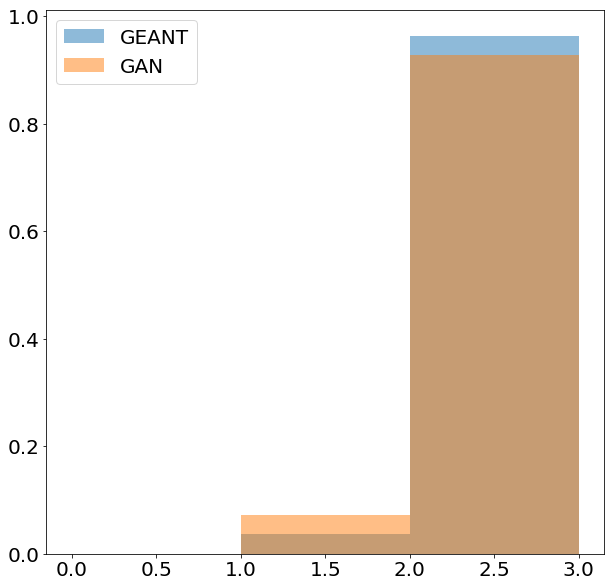

In [193]:
bins = [0, 1, 2, 3]
plt.figure(figsize=(10, 10))
_ = plt.hist(depth_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(depth_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

In [194]:
etot_orig = total_energy(d)
etot_gen = total_energy(dgen)

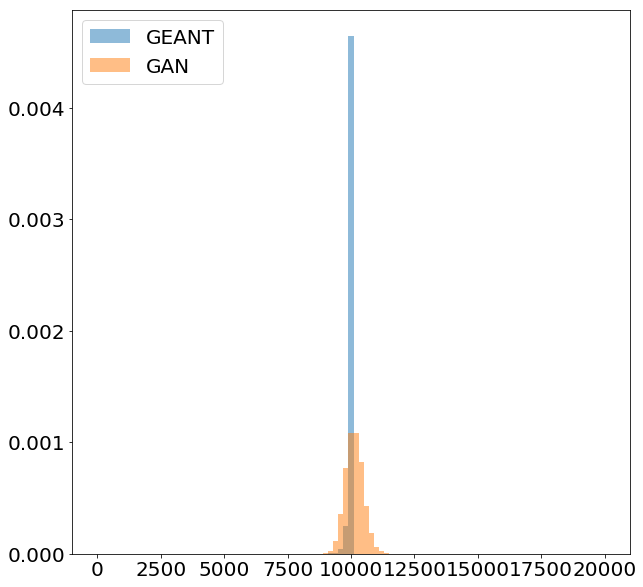

In [195]:
bins = np.linspace(0, 20000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

In [196]:
e2_orig = energy('2', d)
e2_gen = energy('2', dgen) 
e1_orig = energy('1', d)
e1_gen = energy('1', dgen) 
e0_orig = energy('0', d)
e0_gen = energy('0', dgen)

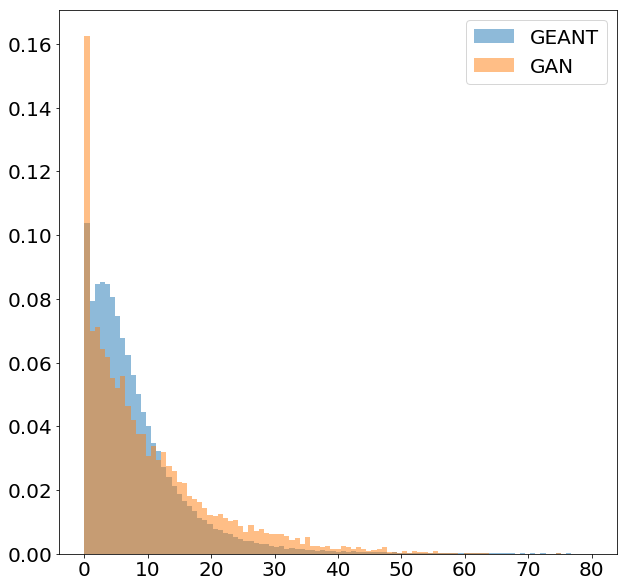

In [197]:
bins = np.linspace(0, 80, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e2_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

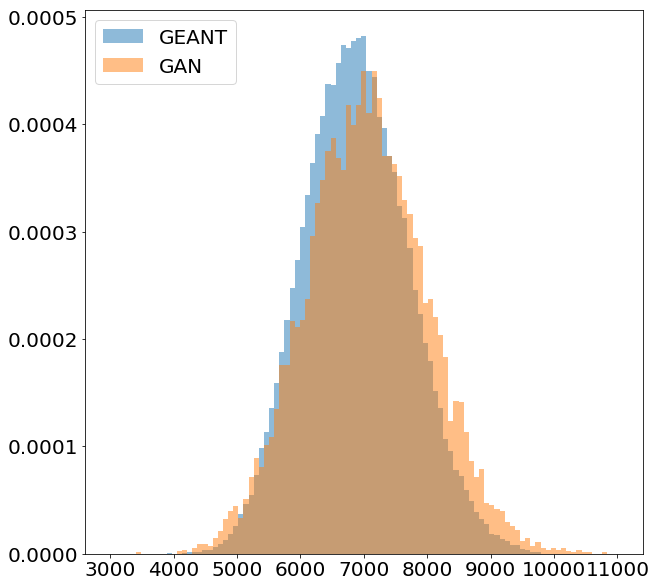

In [198]:
bins = np.linspace(3000, 11000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e1_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

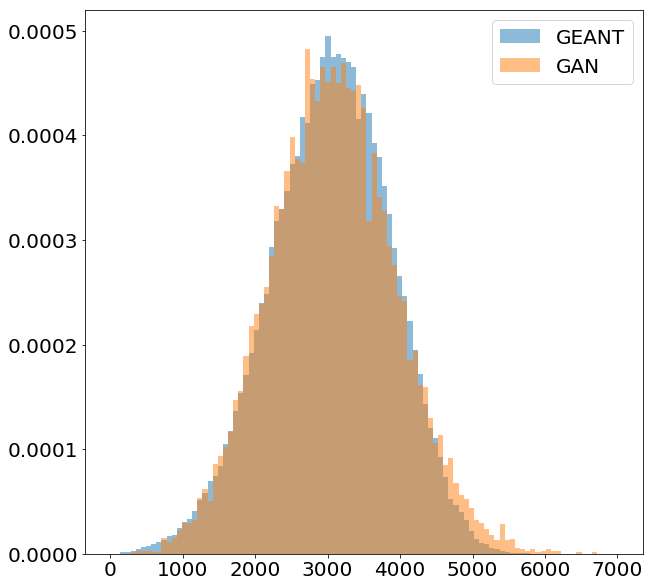

In [199]:
bins = np.linspace(0, 7000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e0_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

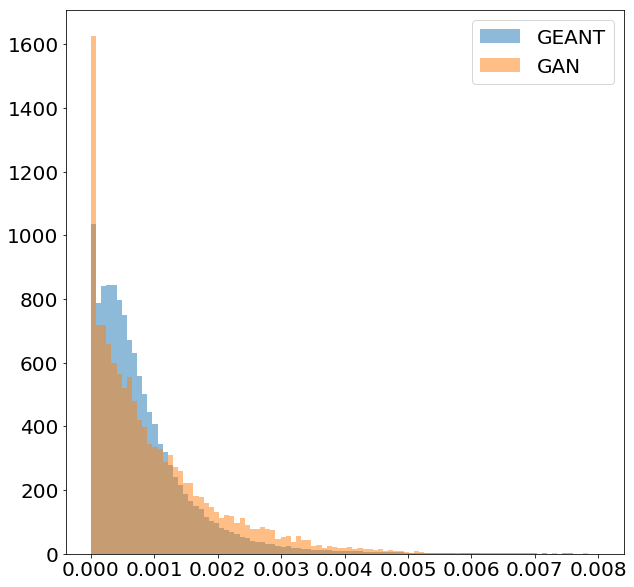

In [200]:
bins = np.linspace(0, 0.008, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e2_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

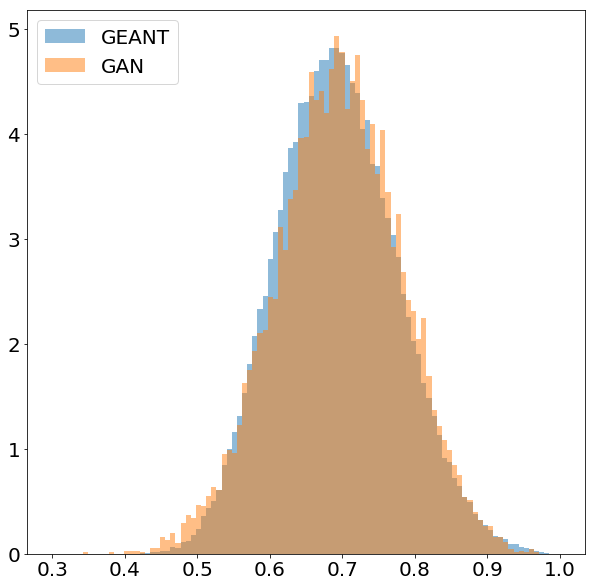

In [201]:
bins = np.linspace(0.3, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e1_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

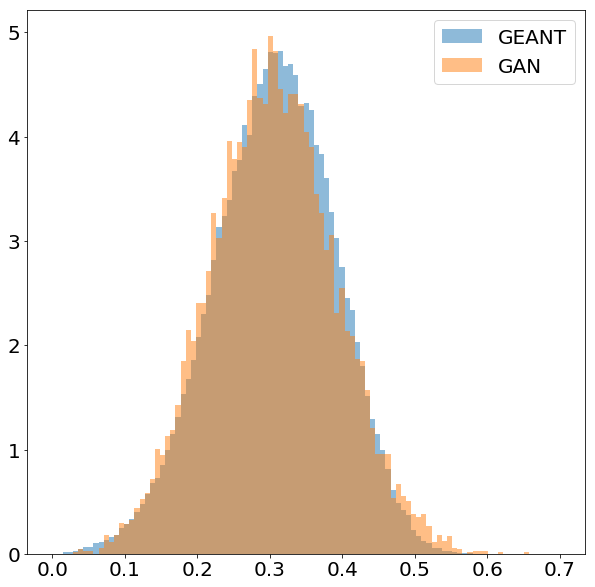

In [202]:
bins = np.linspace(0, 0.7, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(e0_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

In [203]:
lateral_depth_orig = lateral_depth(d)
lateral_depth_gen = lateral_depth(dgen)

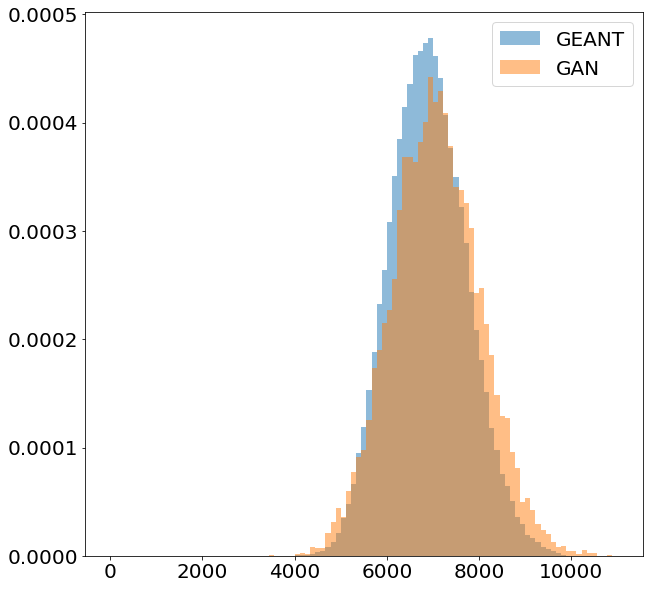

In [204]:
bins = np.linspace(0, 11000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

In [205]:
lateral_depth2_orig = lateral_depth2(d)
lateral_depth2_gen = lateral_depth2(dgen)

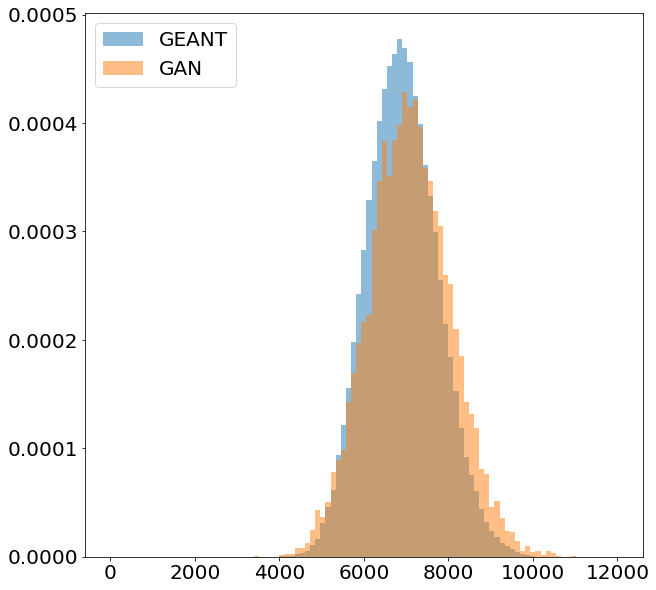

In [206]:
bins = np.linspace(0, 12000, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth2_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth2_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

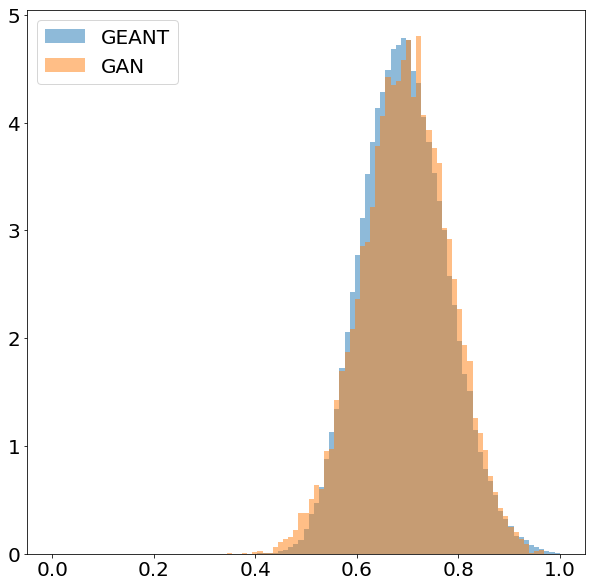

In [207]:
# shower depth
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

In [208]:
shower_depth_width_orig = shower_depth_width(
    lateral_depth_orig, lateral_depth2_orig, etot_orig)
shower_depth_width_gen = shower_depth_width(
    lateral_depth_gen, lateral_depth2_gen, etot_gen)

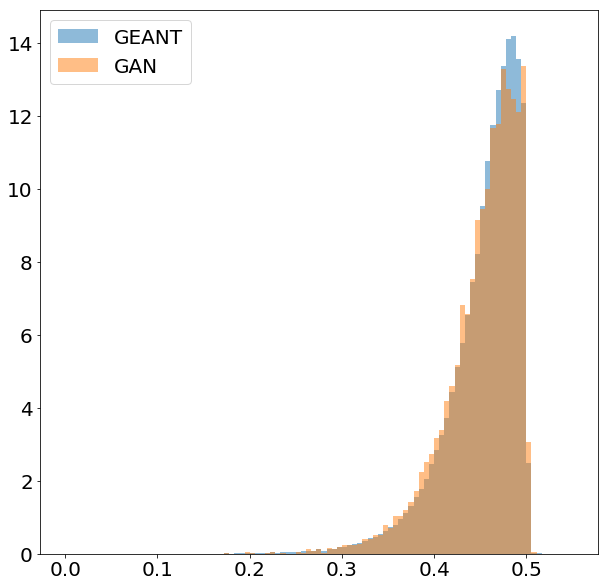

In [209]:
# shower depth width
bins = np.linspace(0, 0.55, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(shower_depth_width_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(shower_depth_width_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left')

In [210]:
lateral_width0_orig = layer_lateral_width('0', d)
lateral_width1_orig = layer_lateral_width('1', d)
lateral_width2_orig = layer_lateral_width('2', d)
lateral_width0_gen = layer_lateral_width('0', dgen)
lateral_width1_gen = layer_lateral_width('1', dgen)
lateral_width2_gen = layer_lateral_width('2', dgen)

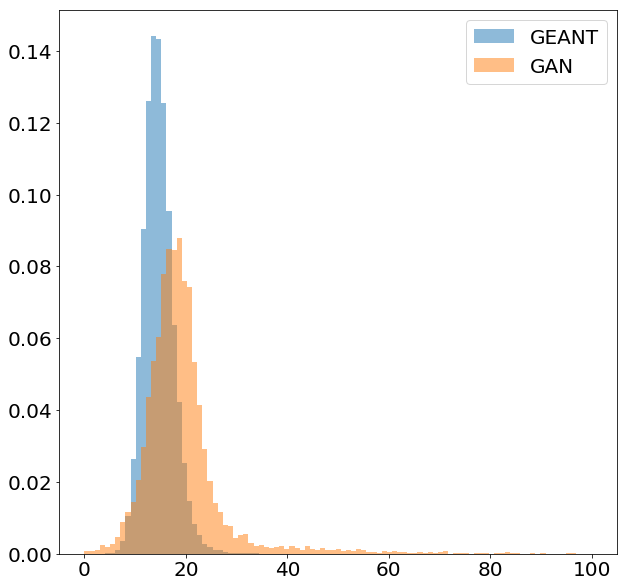

In [211]:
# layer 0 lateral width
bins = np.linspace(0, 100, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width0_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width0_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

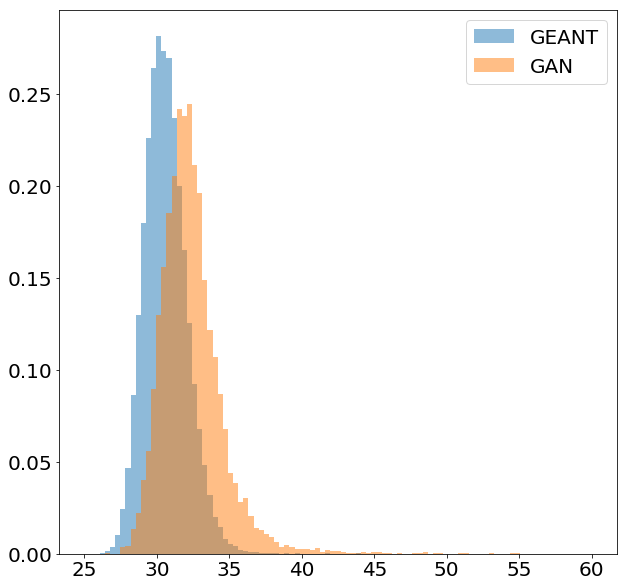

In [212]:
# layer 1 lateral width
bins = np.linspace(25, 60, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width1_orig , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width1_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')

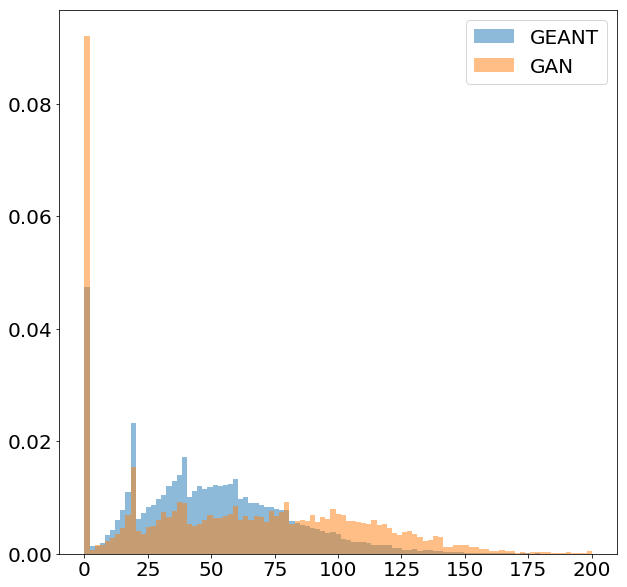

In [213]:
# layer 2 lateral width
bins = np.linspace(0, 200, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width2_orig[np.isfinite(lateral_width2_orig)] , bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
_ = plt.hist(lateral_width2_gen[np.isfinite(lateral_width2_gen)], bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper right')